In [1]:
# from sandbox.celine_knowledge_graph import *
# from sandbox.spacy_experiments import *
# from sandbox.neuralcoref_experiments import *
# from bert_embedding import BertEmbedding

In [2]:
import sys
import spacy
import neuralcoref
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored

import warnings
warnings.filterwarnings("ignore")

nlp = spacy.load("en_core_web_lg")
neuralcoref.add_to_pipe(nlp)

In [3]:
def clean(s):
    s = s.split()
    # remove everything from "-lrb-" to "-rrb-"
    s2 = []
    in_paren = False
    for ixw, w in enumerate(s):
        if(w=="-lrb-"):
            in_paren=True
        elif(w=='-rrb-'):
            in_paren=False
        elif(w=="-lsb-" or w=="-rsb-"):
            continue
        elif(ixw <= len(s)-2 and w=="new" and s[ixw+1]==":"):
            continue
        elif(ixw <= len(s)-1 and w==":" and s[ixw-1]=="new"):
            continue
        elif(len(w) > 1 and w[0] == '\''):
            s2[-1] = s2[-1]+w
        elif not in_paren and not (w == '<t>' or w == '</t>'):
            s2.append(w)
        
    return ' '.join(s2)


In [3]:
class KnowledgeGraph:
    
    def __init__(self):
        self.relations = list()
        self.noun_threshold = 0.9
        self.verb_threshold = 0.9
        self.weak_threshold = 0.5
        self.entailment = 0
        self.entailment_dissimilar_verbs = 0.5
        self.dissimilar_verbs = 1
        self.missing_dependencies = 2
        self.contradiction = 3

    # ==========================================
    # 1) adding to KnowledgeGraph relations 
    # ==========================================
    def add_verb(self, verb):
        self.relations.append(self.get_relation(verb))
        
    ##### extracting relations from sentence #####
    def get_relation(self, verb):
        # get all equivalent verbs
        verb_cluster = self.get_verb_cluster(verb)
        actors = []
        acteds = []
        
        # get all actors/acteds of verbs in equivalencies
        for verb in verb_cluster:
            actors += self.get_actors(verb)
            acteds += self.get_acteds(verb)
        return verb_cluster, actors, acteds
    
    # =========================================
    # 2) looks through verb's children for
    # verb equivalencies (xcomp)
    # =========================================
    def get_verb_cluster(self, verb):
        verb_cluster = [verb]
        for child in verb.children:
            if child.dep_ == "xcomp":# or child.dep_ == "ccomp":
                verb_cluster.append(child)
        return verb_cluster
        
    def get_actors(self, verb):
        actors = []
        for child in verb.children:
            # child is a nominative subject
            if child.dep_ == "nsubj":
                actors.append(child)
            # child is something like "by"
            elif child.dep_ == "agent":  
                # passive, look for true actor
                for grandchild in child.children:
                    if grandchild.dep_ == "pobj":
                        actors.append(grandchild)
        return actors

    def get_acteds(self, verb):
        acteds = []
        for child in verb.children:
            #child is direct object or passive subject
            if child.dep_ == "dobj" or child.dep_ == "nsubjpass":
                acteds.append(child)
        return acteds

    # =========================================
    # 3) checking hypothesis relation against 
    # premise's KnowledgeGraph relations
    # =========================================
    def query_relation(self, hypothesis):
        missing_dependencies = []
        contradiction = []
        for premise in self.relations:
            r = self.implied_relation(premise, hypothesis)

            # once we find that hypothesis is contained, accept this relation as verified
            # if the verb similarity is too low, we make note of this but still mark it as entailed
            if r[0] == self.entailment:
                return r[0], [(premise,r[1])]
            elif r[0] == self.missing_dependencies:
                missing_dependencies.append((premise, r[1]))
            elif r[0] == self.contradiction:
                contradiction.append((premise, r[1]))
        if len(contradiction) > 0:
            return self.contradiction, contradiction
        return self.missing_dependencies, missing_dependencies
    
    # check if a hypothesis is verified by a premise 
    # returns (result, proof)
    def implied_relation(self, premise, hypothesis):
        # premise[0] and hypothesis[0] is a list (verb cluster)
        verb_similarity, best_pair = self.verb_same(premise[0], hypothesis[0])
        if verb_similarity < self.verb_threshold:
            return self.dissimilar_verbs, hypothesis
        
        # check setminus of premise \ hypothesis
        actor_actor = self.noun_intersect_setminus(premise[1], hypothesis[1])
        acted_acted = self.noun_intersect_setminus(premise[2], hypothesis[2])
        actor_acted = self.noun_intersect_setminus(premise[1], hypothesis[2])
        acted_actor = self.noun_intersect_setminus(premise[2], hypothesis[1])

        contained_deps = actor_actor[0] + acted_acted[0]
        missing_deps = actor_actor[1] + acted_acted[1]
        contradiction_deps = actor_acted[0] + acted_actor[0]
        
        if len(missing_deps) == 0:
            return self.entailment, ("verb similarity:", verb_similarity,
                    "contained dependences:", contained_deps)
        if len(contradiction_deps) > 0:
            return self.contradiction, ("verb similarity:", verb_similarity,
                    "contradictory dependences:", contradiction_deps)
        return self.missing_dependencies, ("verb similarity:",
                verb_similarity, "missing dependencies:", missing_deps)

    
    # ========================
    # verb helper functions
    # ========================
    # v1 comes from premise/source, v2 comes from hypothesis/output
    def verb_same(self, v1_cluster, v2_cluster):
        maximum_similarity = 0
        maximum_pair = None
        for v1 in v1_cluster:
            for v2 in v2_cluster:
                similarity = v1.similarity(v2)
                if(similarity > maximum_similarity):
                    maximum_similarity = similarity
                    maximum_pair = v1, v2
        return maximum_similarity, maximum_pair
    

    # ========================
    # noun helper functions
    # ========================
    def noun_intersect_setminus(self, supset, subset):
        contained_nouns = []
        missing_nouns = []
        for n in subset:
            contained = False
            for n2 in supset:
                r = self.noun_same(n, n2)
                if verbose:
                    print(n, n2, r)
                if r[0]:
                    contained = True
                    contained_nouns.append((n, n2, r[1]))
                    continue
            if not contained:
                missing_nouns.append(n)
        return contained_nouns, missing_nouns

    def noun_same(self, n1, n2):
        tokens1 = self.get_valid_cluster_tokens(n1)
        tokens2 = self.get_valid_cluster_tokens(n2)
        if len(tokens1) == 0 or len(tokens2) == 0:
            tokens1 = self.get_valid_cluster_tokens(n1, True)
            tokens2 = self.get_valid_cluster_tokens(n2, True)
        maximum_similarity = 0
        maximum_pair = None
        for token1 in tokens1:
            for token2 in tokens2:
                token_similarity = token1.similarity(token2)
                if token_similarity > maximum_similarity:
                    maximum_similarity = token_similarity
                    maximum_pair = token1, token2
        if maximum_similarity > self.noun_threshold:
            return True, ("best match:", maximum_similarity, maximum_pair)
        return False, ("best match:", maximum_similarity, maximum_pair)
    
    def get_valid_cluster_tokens(self, noun, use_generic=False):
        tokens = list()
        if (noun.pos_ == 'PRON' or noun.pos_ == 'DET') and noun.head.dep_ == 'relcl':
            # the head is the verb of the relative clause
            # the head of the verb should be the noun this thing refers to
            if verbose:
                print("found relative clause, replacing", noun, "with", noun.head.head)
            noun = noun.head.head
        for cluster in noun._.coref_clusters:
            for span in cluster:
                for token in span:
                    if use_generic or not self.is_generic(token):
                        if verbose and self.is_generic(token):
                            print(colored("warning:", "yellow"), "using generic token", noun)
                        tokens.append(token)
        if len(tokens) == 0:
            if use_generic or not self.is_generic(noun):
                if verbose and self.is_generic(noun):
                    print(colored("warning:", "yellow"), "using generic token", noun)
                tokens.append(noun)
        return tokens 

    def is_generic(self, token):
        return token.pos_ == "PRON" or token.pos_ == "DET"


In [4]:
def test(src, gen):
#     print("source:", src_line[:100])
#     print("summary:", gen_line[:100])
    src = nlp(src)
    gen = nlp(gen)
#     print("clusters:", src._.coref_clusters)
    kg = KnowledgeGraph()

    # put all actors/acteds for each verb into knowledge graph
    for ixt, token in enumerate(src):
        if token.pos_ == "VERB":
            kg.add_verb(token)
    important_relations = []
    contained = 0
    missing = 0
    contradiction = 0
    total = 0
    
    for token in gen:
        # ignore xcomp verbs "tried TO EAT" since will later be added to verb cluster
        # still adds was/has/is/aux verbs though
        if token.pos_ == "VERB" and not(token.dep_=='xcomp'):# or token.dep_=='ccomp'):
            relation = kg.get_relation(token)
            # skip those relations with no actors/acteds
            if (len(relation[1]) + len(relation[2]) == 0):
                continue
            
            total += 1
            r = kg.query_relation(relation)
            if r[0] == kg.entailment:
                contained += 1
                important_relations.append(('contained', relation, r[1]))
                if(verbose):
                    print("contained |", relation, "|", r[1])
#             elif r[0] == kg.entailment_dissimilar_verbs:
#                 missing += 1
#                 important_relations.append(('contained-noverb', relation, r[1]))
#                 if(verbose):
#                     print("contained-noverb |", relation, "|", r[1])
            elif r[0] == kg.missing_dependencies:
                missing += 1
                important_relations.append(('missing', relation, r[1]))
                if(verbose):
                    print(colored("missing", "yellow"), "|", relation, "|", r[1])
            elif r[0] == kg.contradiction:
                contradiction += 1
                important_relations.append(('contradiction', relation, r[1]))
                if(verbose):
                    print(colored("contradiction", "red"), "|", relation, "|", r[1])
    
    important_relations = sorted(important_relations)
    colored_src, colored_gen = visualize([word.text for word in src], [word.text for word in gen], important_relations)
    
    if total == 0:
        return important_relations, (0.0, 0.0, 0.0), (colored_src, colored_gen)
    return important_relations, (100.0 * contained / total, 
                                 100.0 * missing / total, 
                                 100.0 * contradiction / total), (colored_src, colored_gen)


In [5]:
def visualize(src0, gen0, important_relations):
    colors = {'contained':lambda text: '\033[0;32m' + text + '\033[0m', 
#               'contained-noverb':lambda text: '\033[0;95m' + text + '\033[0m', 
              'missing':lambda text: '\033[0;33m' + text + '\033[0m', 
              'contradiction':lambda text: '\033[0;31m' + text + '\033[0m'}

    colored_src = src0
    colored_gen = gen0
    for order in ['missing', 'contained-noverb', 'contained', 'contradiction']:
        for relation_tuple in important_relations:
            result = relation_tuple[0]
            relation = relation_tuple[1]
            proof = relation_tuple[2]
            if not(result == order):
                continue
            # color output doc
            verbs = relation[0]
            actors = relation[1]
            acteds = relation[2]
            for verb in verbs:
                colored_gen[verb.i] = colors[result](verb.text)
            for a in actors:
                colored_gen[a.i] = colors[result](a.text)
            for a in acteds:
                colored_gen[a.i] = colors[result](a.text)

            # color source doc
            for p in proof:
                for verb in p[0][0]:
                    colored_src[verb.i] = colors[result](verb.text)
                for a in p[0][1]:
                    colored_src[a.i] = colors[result](a.text)
                for a in p[0][2]:
                    colored_src[a.i] = colors[result](a.text)

    colored_src = ' '.join(colored_src)
    colored_gen = ' '.join(colored_gen)

    return colored_src, colored_gen

In [29]:
# returns average number of tokens copied = max copy length / unique phrases copied
def avg_copy_length(src,gen):
    src = src.split()
    gen = gen.split()
    substrings = {}
    for ixgw,word in enumerate(gen):
        substrings[ixgw] = []
    
    avg_length = 0
    num_copied = 0
    ixgw = 0
    while(ixgw < len(gen)):
        gen_word = gen[ixgw]
        max_js = []
        src_ixs = []
        for ixsw, src_word in enumerate(src):
            j = 0
            while(ixgw+j <= len(gen) and ixsw+j <= len(src) and src[ixsw:ixsw+j] == gen[ixgw:ixgw+j]):
                j += 1
            if(len(max_js) == 0 or j > max_js[0]):
                max_js = [j]
                src_ixs = [ixsw]
            elif(j == max_js[0]):
                max_js.append(j)
                src_ixs.append(ixsw)
        substrings[ixgw] = ([gen[ixgw:ixgw+max_j-1] for max_j in max_js], src_ixs)
        ixgw += 1
        
    for ixgw,gen_word in enumerate(gen):
#         substr = substrings[ixgw][0]
#         src_ix = substrings[ixgw][1]
        contained = False
        for src_ix in substrings[ixgw][1]:
            if ixgw > 0 and src_ix-1 in substrings[ixgw-1][1]:
                contained=True
                break
        
        if not contained:
            if(len(substrings[ixgw][0])>0):
                num_copied += 1
#                 print(substrings[ixgw])
#                 print(len(substrings[ixgw][0][0]))
                avg_length += len(substrings[ixgw][0][0])
    
    avg_length = 0 if num_copied == 0 else avg_length/num_copied
    
    return avg_length 

In [33]:
verbose = True
src_path = "data/fast-abs-RL/articles.txt"
tgt_path = "data/fast-abs-RL/reference.txt"
gen_path = "data/fast-abs-RL/decoded.txt"

line_num = 2
scores = []
src_lines = []
tgt_lines = []
gen_lines = []
with open(src_path) as src:
    with open(tgt_path) as tgt:
        with open(gen_path) as gen:
            for i, (orig_src_line, orig_tgt_line, gen_line) in enumerate(zip(src, tgt, gen)):
    #             if i < 30:
    #                 continue
                if line_num > 0 and not i == line_num:
                    continue
                if line_num == 0 and i >= 40:
                    break
                orig_src_line = clean(orig_src_line)
                orig_tgt_line = clean(orig_tgt_line)
                src_line = orig_tgt_line + ' ' + orig_src_line
                src_lines.append(orig_src_line)
                tgt_lines.append(orig_tgt_line)
                gen_line = clean(gen_line)
                gen_lines.append(gen_line)
                important_relations, score, (colored_src, colored_gen) = test(src_line, gen_line)
                print("===========================================================================================")
                print(f"Src {i}:"%{i:i}, colored_src)
                print("===========================================================================================")
                print(f"Summary {i}:"%{i:i}, colored_gen)
                print("Score:", score)
                avg_length = avg_copy_length(orig_src_line, gen_line)
                print("Avg copy length:", avg_length)
                print("===========================================================================================")
                print("===========================================================================================")
                scores.append(score)



moses meredith (False, ('best match:', 0.3165538, (moses, ellie)))
moses trey (False, ('best match:', 0.329055, (moses, trey)))
moses ellie (False, ('best match:', 0.3165538, (moses, ellie)))
missing | ([be], [moses], []) | [(([be], [meredith], []), ('verb similarity:', 1.0, 'missing dependencies:', [moses])), (([asked, be], [trey], [ellie]), ('verb similarity:', 1.0, 'missing dependencies:', [moses])), (([be], [], []), ('verb similarity:', 1.0, 'missing dependencies:', [moses]))]
trey mother (False, ('best match:', 0.07276874, (trey, mother)))
missing | ([was], [trey], []) | [(([was], [], []), ('verb similarity:', 1.0, 'missing dependencies:', [trey])), (([was], [], []), ('verb similarity:', 1.0, 'missing dependencies:', [trey])), (([was], [mother], []), ('verb similarity:', 1.0, 'missing dependencies:', [trey]))]
helson helson (True, ('best match:', 1.0, (helson, helson)))
staff staff (True, ('best match:', 1.0, (staff, staff)))
staff helson (False, ('best match:', 0, None))
helson s

In [34]:
for token in nlp(src_lines[0]):
    print(token, token.dep_, token.pos_, token.head)

( punct PUNCT cnn
cnn ROOT PROPN cnn
) punct PUNCT cnn
he nsubj PRON 's
's ROOT VERB 's
a det DET recruit
blue amod ADJ chip
chip compound NOUN recruit
college compound NOUN basketball
basketball compound NOUN recruit
recruit attr NOUN 's
. punct PUNCT 's
she nsubj PRON 's
's ROOT VERB 's
a det DET freshman
high amod ADJ school
school compound NOUN freshman
freshman attr NOUN 's
with prep ADP freshman
down amod ADJ syndrome
syndrome pobj NOUN with
. punct PUNCT 's
at prep ADP be
first amod ADJ glance
glance compound NOUN moses
trey compound NOUN moses
moses pobj PROPN at
and cc CCONJ moses
ellie compound PROPN meredith
meredith nsubj NOUN be
could aux VERB be
n't neg ADV be
be ROOT VERB be
more advmod ADV different
different acomp ADJ be
. punct PUNCT be
but cc CCONJ all
all ROOT DET all
that nsubj DET changed
changed relcl VERB all
thursday npadvmod NOUN changed
when advmod ADV asked
trey nsubj NOUN asked
asked advcl VERB changed
ellie dobj NOUN asked
to aux PART be
be xcomp VERB aske

. punct PUNCT stop
` punct PUNCT wait
` punct PUNCT wait
ellie nsubj NOUN wait
ca aux VERB wait
n't neg ADV wait
wait ROOT VERB wait
to aux PART go
go xcomp VERB wait
dress compound NOUN shopping
shopping dobj NOUN go
' punct PUNCT wait
' punct PUNCT wait
her poss DET mother
mother nsubj NOUN said
said ROOT VERB said
. punct PUNCT said
` punct PUNCT `
` punct PUNCT told
because mark ADP told
i nsubj PRON told
've aux VERB told
only advmod ADV told
told ROOT VERB told
about quantmod ADP million
a quantmod DET million
million nummod NUM people
people dobj NOUN told
! punct PUNCT told
'' punct PUNCT told
ellie nsubj PROPN interjected
interjected ROOT VERB interjected
. punct PUNCT interjected


In [35]:
for token in nlp(gen_lines[0]):
    print(token, token.dep_, token.pos_, token.head)

trey compound VERB moses
moses nsubj PROPN be
and cc CCONJ moses
ellie compound PROPN meredith
meredith conj NOUN moses
could aux VERB be
n't neg ADV be
be ROOT VERB be
more advmod ADV different
different acomp ADJ be
. punct PUNCT be
trey nsubj NOUN was
was ROOT VERB was
a det DET star
star attr NOUN was
on prep ADP star
eastern amod ADJ school
high amod ADJ school
school poss NOUN team
's case PART school
basketball compound NOUN team
team pobj NOUN on
in prep ADP team
louisville pobj NOUN in
, punct PUNCT louisville
kentucky appos NOUN louisville
. punct PUNCT was
trina compound PROPN helson
helson nsubj NOUN alerted
, punct PUNCT helson
a det DET teacher
teacher appos NOUN helson
at prep ADP teacher
eastern amod ADJ at
, punct PUNCT alerted
alerted ROOT VERB alerted
the det DET school
school poss NOUN staff
's case PART school
newspaper compound NOUN staff
staff dobj NOUN alerted
. punct PUNCT alerted
trey nsubj NOUN made
made ROOT VERB made
the det DET posal
prom compound NOUN pos

# Score plot

In [66]:
scores = np.load("sandbox/scores.npy")

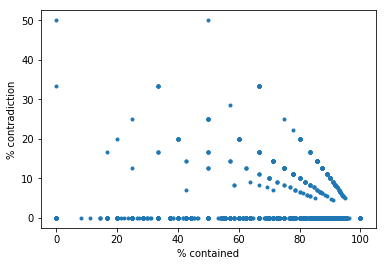

In [79]:
plt.scatter(scores[:,0], scores[:,2], marker='.')
plt.xlabel("% contained")
plt.ylabel("% contradiction")
plt.show()

# ROUGE analysis

In [11]:
from rouge import Rouge

In [15]:
rouge = Rouge()
scores = rouge.get_scores(gen_lines[0], tgt_lines[0])

In [17]:
rouge.get_scores(gen_lines[1], tgt_lines[1])

[{'rouge-1': {'f': 0.41999999503200003,
   'p': 0.45652173913043476,
   'r': 0.3888888888888889},
  'rouge-2': {'f': 0.18032786393845757,
   'p': 0.20754716981132076,
   'r': 0.15942028985507245},
  'rouge-l': {'f': 0.4147252747249494,
   'p': 0.45652173913043476,
   'r': 0.3888888888888889}}]

# Trying BERT embeddings....

In [35]:
bert_embedding = BertEmbedding()
embed = bert_embedding(src_lines[0].split(' . '))

['relations between iran and saudi arabia have always been thorny , but rarely has the state of affairs been as venomous as it is today',
 'tehran and riyadh each point to the other as the main reason for much of the turmoil in the middle east',
 'in its most recent incarnation , the iranian-saudi conflict by proxy has reached yemen in a spiral that both sides portray as climatic',
 "for riyadh and its regional allies , the saudi military intervention in yemen -- `` operation decisive storm'' -- is the moment the sunni arab nation finally woke up to repel the expansion of shia-iranian influence",
 "for tehran and its regional allies -- including the houthi movement in yemen -- saudi arabia's actions are in defense of a retrogressive status quo order that is no longer tenable",
 'and yet both sides have good reasons to want to stop the yemeni crisis from spiraling out of control and evolving into an unwinnable war',
 'when iranian president hassan rouhani was elected in june 2013 , he p

In [51]:
embed[0][0]

['relations',
 'between',
 'iran',
 'and',
 'saudi',
 'arabia',
 'have',
 'always',
 'been',
 'thorny',
 ',',
 'but',
 'rarely',
 'has',
 'the',
 'state',
 'of',
 'affairs',
 'been',
 'as',
 'venomous']

In [54]:
# for i in range(len(embed[0][1])):
#     plt.scatter([embed[0][1][i][0]], [embed[0][1][i][1]], label=embed[0][0][i])
# # plt.scatter([embed[0][1][i][0] for i in range(len(embed[0][1]))], 
# #             [embed[0][1][i][1] for i in range(len(embed[0][1]))])
# # plt.scatter([embed[0][1][2][0]], [embed[0][1][2][1]])
# # plt.scatter([embed[0][1][4][0]], [embed[0][1][4][1]])
# # plt.scatter([embed[0][1][5][0]], [embed[0][1][5][1]])
# plt.legend()
# plt.show()

In [45]:
np.linalg.norm(embed[0][1][4] - embed[0][1][5])

10.376158

In [50]:
bert_embedding = BertEmbedding()

Vocab file is not found. Downloading.


In [63]:
i=0
with open("data/test.txt.src.tagged.shuf.400words") as src:
    with open("data/bottom_up_cnndm_015_threshold.out") as gen:
        for src_line0, gen_line0 in zip(src, gen):
            if(i >= 8):
                break
#             print(src_line0)
            i+=1

In [75]:
sentence = gen_line.split(' . ')

In [91]:
result = bert_embedding(["I ate a dog", "I ate a cat"])


In [92]:
result[0][0]

['i', 'ate', 'a', 'dog']

In [93]:
np.linalg.norm(result[1][1][3]- result[0][1][3])

6.3448873

In [94]:
np.linalg.norm(result[1][1][1]- result[0][1][1])

2.9955516

# Analysis

In [213]:
import statsmodels.api as sm
import pandas as pd

In [313]:
index = 3999
num_use = 1000
models = ['fast-abs-RL', 'bottom-up', 'pointer-generator']
colors = {'fast-abs-RL':'C0', 
          'bottom-up':'C1', 
          'pointer-generator':'C2'}
scores = {}
contradiction = {}
rouge = {}
average_copy_lengths = {}
for model in models:
    scores[model] = np.load("./experiments/"+model+"/scores"+str(index)+".npy")
    contradiction[model] = np.load("./experiments/"+model+"/contradiction_scores"+str(index)+".npy")
    rouge[model] = np.load("./experiments/"+model+"/rouge"+str(index)+".npy")
    average_copy_lengths[model] = np.load("./experiments/"+model+"/average_copy_lengths"+str(index)+".npy")

In [314]:
remove_indices = average_copy_lengths['fast-abs-RL']>0

In [315]:
for model in ['bottom-up', 'pointer-generator', 'fast-abs-RL']:
    scores[model] = scores[model][remove_indices][:num_use]
    contradiction[model] = contradiction[model][remove_indices][:num_use]
    average_copy_lengths[model] = average_copy_lengths[model][remove_indices][:num_use]

In [316]:
rouge_scores = {}
for i in ['1','2','L']:
    rouge_scores[i] = {}
    for model in models:
        rouge_scores[i][model] = np.array([100.*rouge[model][j]['rouge-'+i.lower()]['f'] for j in range(len(rouge[model]))])[remove_indices][:num_use]
        

In [317]:
all_data = {}
for model in models:
    all_data[model] = pd.DataFrame(data=np.array([scores[model],
                                                  contradiction[model],
                                                  average_copy_lengths[model],
                                                  rouge_scores['1'][model],
                                                  rouge_scores['2'][model],
                                                  rouge_scores['L'][model]]).T,
                                   columns = ['Percent_relations_contained', 
                                              'Percent_relations_contradiction', 
                                              'Average_copy_length', 
                                              'ROUGE-1', 'ROUGE-2', 'ROUGE-L'])

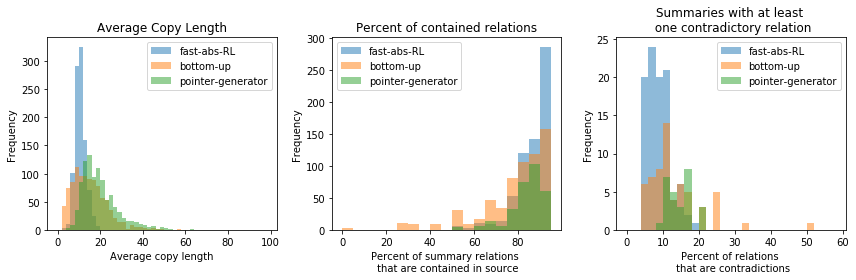

In [318]:
f, ax = plt.subplots(1,3, figsize=(12,4))
# average copy length
for model in models:
    ax[0].hist(average_copy_lengths[model], label=model, alpha=0.5, bins = [2*i for i in range(50)],
            color=colors[model])
ax[0].legend()
ax[0].set_title("Average Copy Length")
ax[0].set_xlabel("Average copy length")
ax[0].set_ylabel("Frequency")
# plt.tight_layout()
# plt.show()
# f.savefig("./figs/average_copy_lengths.png")

# contained
for model in models:
    ax[1].hist(scores[model], label=model, alpha=0.5, bins = [5*i for i in range(20)],
            color=colors[model])
ax[1].legend()
ax[1].set_title("Percent of contained relations")
ax[1].set_xlabel("Percent of summary relations \n that are contained in source")
ax[1].set_ylabel("Frequency")
# plt.tight_layout()
# plt.show()
# f.savefig("./figs/contained.png")

# at least one contradiction
for model in models:
    ax[2].hist(contradiction[model][contradiction[model]>0], label=model, alpha=0.5, bins = [2*i for i in range(30)],
            color = colors[model])
ax[2].legend()
ax[2].set_title("Summaries with at least \n one contradictory relation")
ax[2].set_xlabel("Percent of relations \n that are contradictions")
ax[2].set_ylabel("Frequency")
plt.tight_layout()
plt.show()
f.savefig("./figs/all_hists.png")

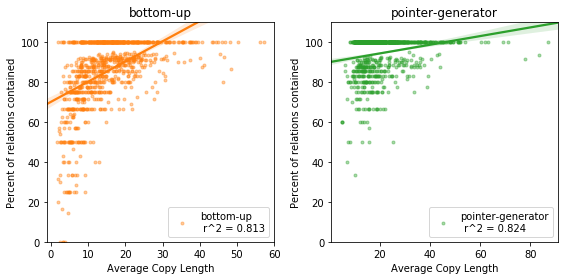

In [328]:
# copy length vs contained
f, ax = plt.subplots(1,2, figsize=(8,4))
for ix, model in enumerate(['bottom-up', 'pointer-generator']):
    lin = sm.OLS(scores[model], average_copy_lengths[model])
    results = lin.fit()
    ax[ix].scatter(average_copy_lengths[model], scores[model], 
                label=model+f"\n r^2 = {results.rsquared.round(3)}", marker='.', alpha=0.4,
               color=colors[model])
    sns.regplot(average_copy_lengths[model], scores[model], scatter=False,color=colors[model],ax=ax[ix])
#         print(results.summary())
    ax[ix].legend(loc='lower right')
    ax[ix].set_title(model)
    ax[ix].set_xlabel("Average Copy Length")
    ax[ix].set_ylabel("Percent of relations contained")
    ax[ix].set_ylim(0,110)
plt.tight_layout()
plt.show()
f.savefig("./figs/copy-contained-bu-pg.png")

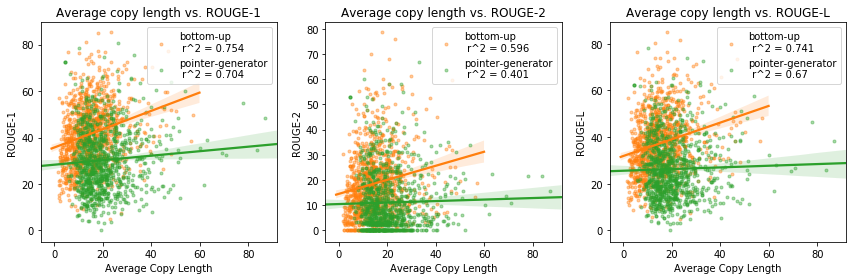

In [327]:
# copy length vs rouge
f, ax = plt.subplots(1,3,figsize=(12,4))
for ix,i in enumerate(['1', '2', 'L']):
    for model in ['bottom-up', 'pointer-generator']:
        lin = sm.OLS(rouge_scores[i][model], average_copy_lengths[model])
        results = lin.fit()
        ax[ix].scatter(average_copy_lengths[model], rouge_scores[i][model], 
                    label=model+f"\n r^2 = {results.rsquared.round(3)}", marker='.', alpha=0.4,
                   color=colors[model])
        sns.regplot(average_copy_lengths[model], rouge_scores[i][model], ax=ax[ix], scatter=False,
                    color=colors[model])
    ax[ix].legend()
    ax[ix].set_title("Average copy length vs. ROUGE-"+i)
    ax[ix].set_xlabel("Average Copy Length")
    ax[ix].set_ylabel("ROUGE-"+i)
plt.tight_layout()
plt.show()
f.savefig("./figs/copy-bu-pg-rouge-"+i+".png")

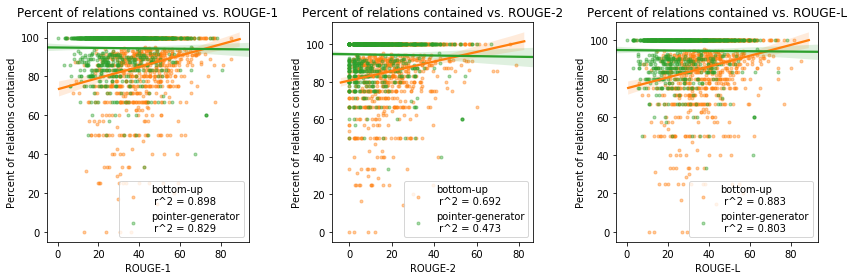

In [329]:
# contained vs rouge
f, ax = plt.subplots(1,3, figsize=(12,4))
for ix,i in enumerate(['1', '2', 'L']):
    for model in ['bottom-up', 'pointer-generator']:
        lin = sm.OLS(scores[model], rouge_scores[i][model])
        results = lin.fit()
        ax[ix].scatter(rouge_scores[i][model], scores[model], 
                    label=model+f"\n r^2 = {results.rsquared.round(3)}", marker='.', alpha=0.4,
                      color=colors[model])
        sns.regplot(rouge_scores[i][model], scores[model], scatter=False, ax=ax[ix], color=colors[model])
    ax[ix].legend(loc='lower right')
    ax[ix].set_title("Percent of relations contained vs. ROUGE-"+i)
    ax[ix].set_ylabel("Percent of relations contained")
    ax[ix].set_xlabel("ROUGE-"+i)
plt.tight_layout()
plt.show()
f.savefig("./figs/scores-bu-pg-rouge-"+i+".png")

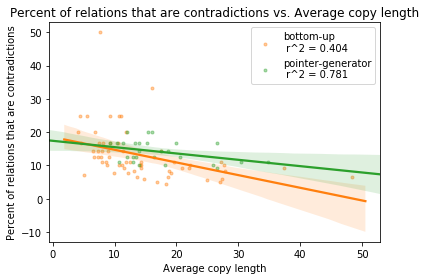

In [323]:
# avg copy vs contradiction
f, ax = plt.subplots(1,1)
ax = [ax]
ix=0
for model in ['bottom-up', 'pointer-generator']:
    lin = sm.OLS(all_data[model]['Percent_relations_contradiction'][all_data[model]['Percent_relations_contradiction'] > 0], 
                 all_data[model]['Average_copy_length'][all_data[model]['Percent_relations_contradiction'] > 0])
    results = lin.fit()
    ax[ix].scatter(all_data[model]['Average_copy_length'][all_data[model]['Percent_relations_contradiction'] > 0], 
                   all_data[model]['Percent_relations_contradiction'][all_data[model]['Percent_relations_contradiction'] > 0], 
                label=model+f"\n r^2 = {results.rsquared.round(3)}", marker='.', alpha=0.4,
                  color = colors[model])
    sns.regplot(all_data[model]['Average_copy_length'][all_data[model]['Percent_relations_contradiction'] > 0], 
                all_data[model]['Percent_relations_contradiction'][all_data[model]['Percent_relations_contradiction'] > 0], 
                scatter=False, ax=ax[ix], color=colors[model])
ax[ix].legend(loc='upper right')
ax[ix].set_title("Percent of relations that are contradictions vs. Average copy length")
ax[ix].set_ylabel("Percent of relations that are contradictions")
ax[ix].set_xlabel("Average copy length")
plt.tight_layout()
plt.show()
f.savefig("./figs/contradictions-avgcopy-bu-pg.png")

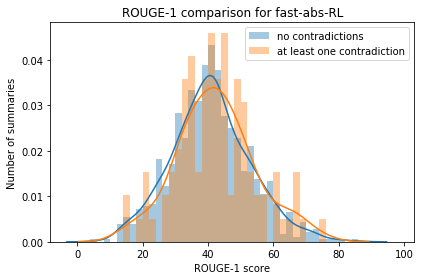

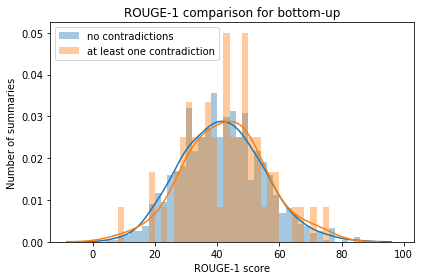

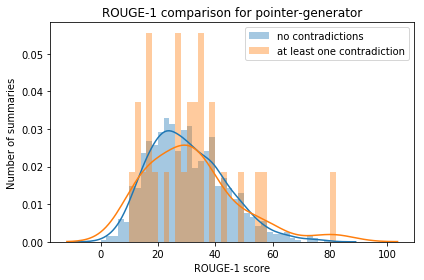

In [324]:
for model in models:
    f, ax = plt.subplots(1,1)
    sns.distplot(all_data[model]['ROUGE-1'][all_data[model]['Percent_relations_contradiction'] == 0], 
                 label="no contradictions", bins=[2*i for i in range(50)])
    sns.distplot(all_data[model]['ROUGE-1'][all_data[model]['Percent_relations_contradiction'] > 0], 
                 label="at least one contradiction", bins=[2*i for i in range(50)])
    plt.legend()
    plt.title("ROUGE-1 comparison for "+model)
    plt.xlabel("ROUGE-1 score")
    plt.ylabel("Number of summaries")
    plt.tight_layout()
    plt.show()
# f.savefig("./figs/contradictions.png")